# $NicheVI$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

import anndata as ad
import numpy as np
import pandas as pd

from rich import print
import os

import scvi

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from scib_metrics.benchmark import Benchmarker
from phenospace.results_analysis import spatial_latent_analysis, SpatialAnalysis

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/

In [3]:
!ls /home/nathanlevy/Data/

BrainAgingSpatialAtlas_MERFISH	Liver_VIZGEN


In [4]:
plots = True

In [5]:
data_dir = "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/"
data_file = "adata_scvi_merfish4w.h5ad"
data_file_name = os.path.splitext(data_file)[0]
print(data_file_name)

adata_scvi_merfish4w

In [6]:
path_to_save = os.path.join("checkpoints", data_file_name)
os.makedirs(path_to_save, exist_ok=True)

In [7]:
adata = ad.read_h5ad(data_dir + data_file)
print(adata)

AnnData object with n_obs × n_vars = 123632 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice', 'n_counts', 'cell_index', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'donor_id_colors', 'log1p', 'neighbors', 'pca', 
'umap'
    obsm: 'X_pca', 'X_scVI', 'X_spVI', 'X_spatial', 'X_umap', 'centroids', 'neighborhood_composition', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [70]:
# adata.obs.clust_annot.value_counts()

In [69]:
# for sample in adata.obs.donor_slice.unique().tolist()[:3]:

#     sc.pl.spatial(adata[adata.obs.donor_slice==sample], spot_size=40, color='cell_type', title=sample)

## First train (linear)scVI

In [8]:
lvae_is_trained = True

In [9]:
if lvae_is_trained:
    vae = scvi.model.LinearSCVI.load(dir_path=path_to_save + "/lvae.pt", adata=adata)

if lvae_is_trained == False:
    scvi.model.LinearSCVI.setup_anndata(
        adata,
        layer="counts",
        batch_key="donor_id",
    )

    vae = scvi.model.LinearSCVI(
        adata,
        gene_likelihood="poisson",
        n_layers=1,
        n_latent=10,
    )

    vae.train(
        max_epochs=30,
        train_size=0.8,
        validation_size=0.2,
        plan_kwargs=dict(n_epochs_kl_warmup=80),
        early_stopping=True,
    )

    vae.save(dir_path=path_to_save + "/lvae.pt", save_anndata=False)

INFO     File checkpoints/adata_scvi_merfish4w/lvae.pt/model.pt already downloaded                                 


In [10]:
adata.obsm["qz1_m"], adata.obsm["qz1_var"] = vae.get_latent_representation(
    return_dist=True
)

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


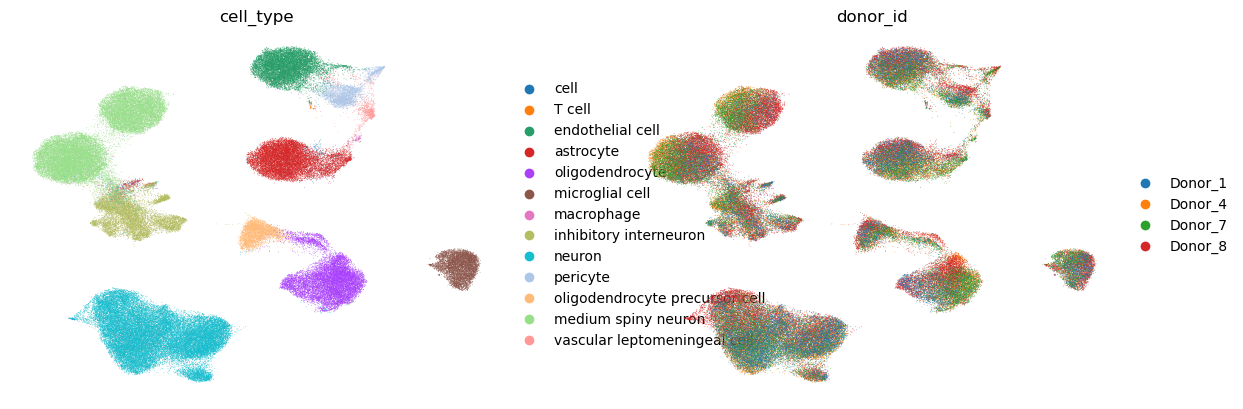

In [12]:
if plots:
    # use scVI latent space for UMAP generation
    sc.pp.neighbors(adata, use_rep="qz1_m")
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata,
        color=["cell_type", "donor_id"],
        ncols=2,
        frameon=False,
    )

# ## 3.2. NicheVI

In [12]:
vae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<Axes: xlabel='epoch'>

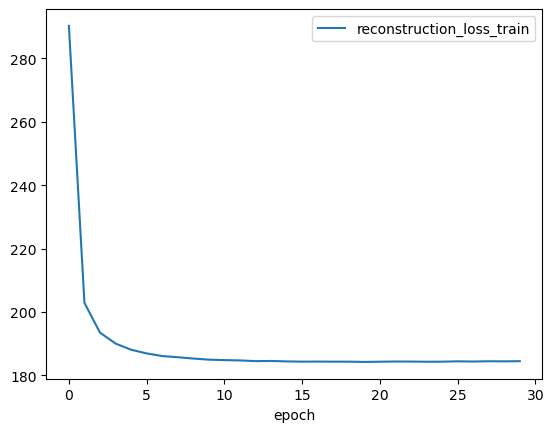

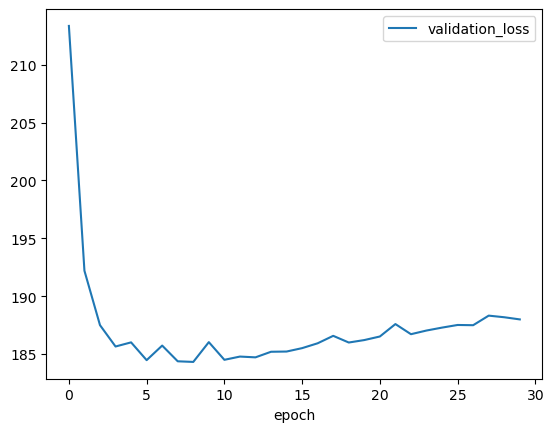

In [88]:
vae.history["reconstruction_loss_train"].plot()
vae.history["validation_loss"].plot()

## Then train $nicheVI$

Parameters

In [11]:
k_nn = 20
n_latent_z1 = adata.obsm["qz1_var"].shape[1]

In [12]:
print(adata.obsm)

AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, spatial, 
qz1_m, qz1_var

In [13]:
# preprocessing function to populate adata.obsm with the keys 'neighborhood_composition',
# 'qz1_m', 'qz1_var', 'niche_indexes', 'niche_distances', 'qz1_m_niche_knn', 'qz1_var_niche_knn', 'qz1_m_niche_ct',
# 'qz1_var_niche_ct'

scvi.model.nicheSCVI.preprocessing_anndata(
    adata,
    niche_composition_key="neighborhood_composition",
    niche_indexes_key="niche_indexes",
    niche_distances_key="niche_distances",
    label_key="cell_type",
    sample_key="donor_slice",
    cell_coordinates_key="centroids",
    k_nn=k_nn,
    latent_mean_key="qz1_m",
    latent_var_key="qz1_var",
    latent_mean_niche_keys=["qz1_m_niche_ct"],
    latent_var_niche_keys=["qz1_var_niche_ct"],
    # latent_mean_ct_prior="qz1_m_niche_ct_prior",
    # latent_var_ct_prior="qz1_var_niche_ct_prior",
)

Saved qz1_m_niche_ct and qz1_var_niche_ct in adata.obsm


In [14]:
adata.obsm["qz1_m_niche_ct"].shape

(123632, 13, 10)

In [15]:
print(adata.obsm.keys())
print(adata.uns.keys())

KeysView(AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, 
spatial, qz1_m, qz1_var, niche_indexes, niche_distances, qz1_m_niche_ct, qz1_var_niche_ct)

dict_keys(['_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'donor_id_colors', 'log1p', 'neighbors', 'pca', 
'umap'])

In [16]:
scvi.model.nicheSCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor_id",
    labels_key="cell_type",
    niche_composition_key="neighborhood_composition",
    niche_indexes_key="niche_indexes",
    niche_distances_key="niche_distances",
    latent_mean_key="qz1_m",
    latent_var_key="qz1_var",
    latent_mean_ct_key="qz1_m_niche_ct",
    latent_var_ct_key="qz1_var_niche_ct",
)

INFO     Using column names from columns of adata.obsm['neighborhood_composition']                                 
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [17]:
niche_setup = {
    # "cell_type_setup": {
    #     "niche_components": "cell_type",
    #     "niche_combination": "aggregate",
    #     "z1_mean": adata.obsm["qz1_m_niche_ct"],
    #     "z1_var": adata.obsm["qz1_var_niche_ct"],
    # },
    # "knn_setup": {
    #     "niche_components": "knn",
    #     "niche_combination": "aggregate",
    #     "z1_mean": adata.obsm["qz1_m_niche_knn"],
    #     "z1_var": adata.obsm["qz1_var_niche_knn"],
    # },
    # "knn_unweighted_setup": {
    #     "niche_components": "knn_unweighted",
    #     "niche_combination": "aggregate",
    #     "z1_mean": adata.obsm["qz1_m_niche_knn"],
    #     "z1_var": adata.obsm["qz1_var_niche_knn"],
    # },
    # "cell_type_unweighted_setup": {
    #     "niche_components": "cell_type_unweighted",
    #     "niche_combination": "aggregate",
    #     "z1_mean": adata.obsm["qz1_m_niche_ct"],
    #     "z1_var": adata.obsm["qz1_var_niche_ct"],
    # },
    "cell_type_setup_mixture": {
        "niche_components": "cell_type",
        "niche_combination": "mixture",
        "z1_mean": adata.obsm["qz1_m_niche_ct"],
        "z1_var": adata.obsm["qz1_var_niche_ct"],
    },
    "cell_type_unweighted_setup_mixture": {
        "niche_components": "cell_type_unweighted",
        "niche_combination": "mixture",
        "z1_mean": adata.obsm["qz1_m_niche_ct"],
        "z1_var": adata.obsm["qz1_var_niche_ct"],
    },
}

In [18]:
nichevae_is_trained = False
save_pt = False
history_setup = {}

In [68]:
for setup in niche_setup.keys():
    print(setup)
    setup_dict = niche_setup[setup]

    nichevae = scvi.model.nicheSCVI(
        adata,
        # z1_mean=setup_dict["z1_mean"],
        # z1_var=setup_dict["z1_var"],
        niche_kl_weight=0,
        niche_compo_weight=0,
        niche_components=setup_dict["niche_components"],
        niche_combination=setup_dict["niche_combination"],
        gene_likelihood="poisson",
        n_layers=1,
        n_latent=n_latent_z1,
        use_batch_norm="both",
        use_layer_norm="none",
    )

    if nichevae_is_trained == False:
        nichevae.train(
            max_epochs=25,
            train_size=0.8,
            validation_size=0.2,
            plan_kwargs=dict(n_epochs_kl_warmup=80),
            early_stopping=True,
            batch_size=128,
        )

        if save_pt:
            nichevae.save(
                dir_path=path_to_save + "/nichevae_" + setup + "_.pt",
                save_anndata=False
                # dir_path="./checkpoints/nichevae_" + setup + "_.pt", save_anndata=False
            )

    if nichevae_is_trained:
        nichevae = scvi.model.nicheSCVI.load(
            dir_path=path_to_save + "/nichevae_" + setup + "_.pt", adata=adata
        )

    history_setup[setup] = nichevae.history
    adata.obsm["X_nicheVI_" + setup] = nichevae.get_latent_representation()

cell_type_setup_mixture

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25/25: 100%|██████████| 25/25 [02:22<00:00,  5.74s/it, v_num=1, train_loss_step=183, train_loss_epoch=181]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████| 25/25 [02:22<00:00,  5.70s/it, v_num=1, train_loss_step=183, train_loss_epoch=181]
INFO     Using column names from columns of adata.obsm['neighborhood_composition']                                 
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


cell_type_unweighted_setup_mixture

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25/25: 100%|██████████| 25/25 [02:24<00:00,  5.87s/it, v_num=1, train_loss_step=186, train_loss_epoch=181]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████| 25/25 [02:24<00:00,  5.78s/it, v_num=1, train_loss_step=186, train_loss_epoch=181]


In [21]:
# # setup_dict = niche_setup["knn_unweighted_setup"]
# # setup_dict = niche_setup["cell_type_setup"]
# setup_dict = niche_setup["knn_setup"]

# nichevae = scvi.model.nicheSCVI(
#     adata,
#     z1_mean=setup_dict["z1_mean"],
#     z1_var=setup_dict["z1_var"],
#     niche_kl_weight=1,
#     niche_components=setup_dict["niche_components"],
#     gene_likelihood="poisson",
#     n_layers=1,
#     n_latent=n_latent_z1,
# )

# if nichevae_is_trained == False:
#     nichevae.train(
#         max_epochs=30,
#         train_size=0.8,
#         validation_size=0.2,
#         plan_kwargs=dict(n_epochs_kl_warmup=80),
#         early_stopping=True,
#         batch_size=128,
#     )

#     nichevae.save(dir_path="./checkpoints/nichevae.pt", save_anndata=False)

# if nichevae_is_trained:
#     nichevae = scvi.model.nicheSCVI.load(
#         dir_path="./checkpoints/nichevae.pt", adata=adata
#     )

# adata.obsm["X_nicheVI"] = nichevae.get_latent_representation()

In [55]:
history_setup.keys()

dict_keys(['cell_type_setup_mixture', 'cell_type_unweighted_setup_mixture'])

In [89]:
history_setup["cell_type_setup_mixture"].keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'niche_CE_validation', 'niche_kl_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'niche_CE_train', 'niche_kl_train'])

<Axes: xlabel='epoch'>

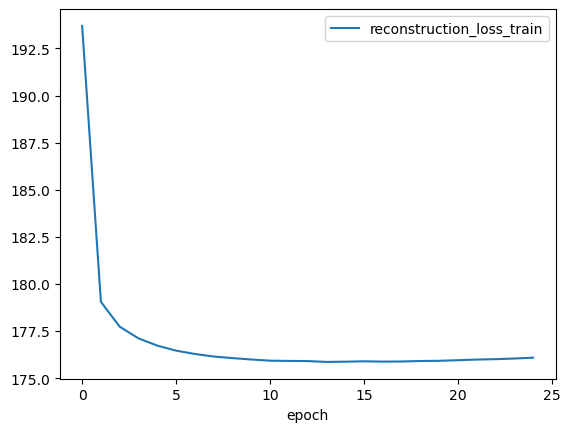

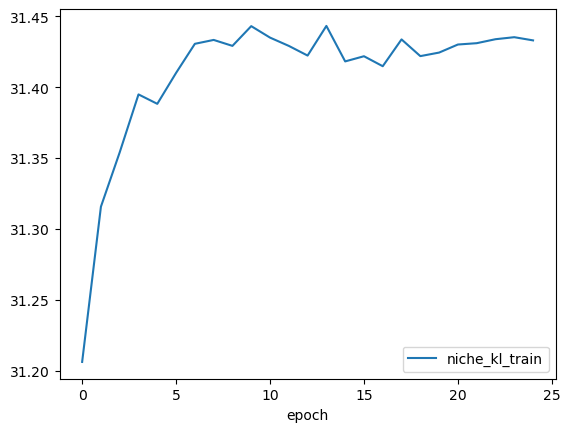

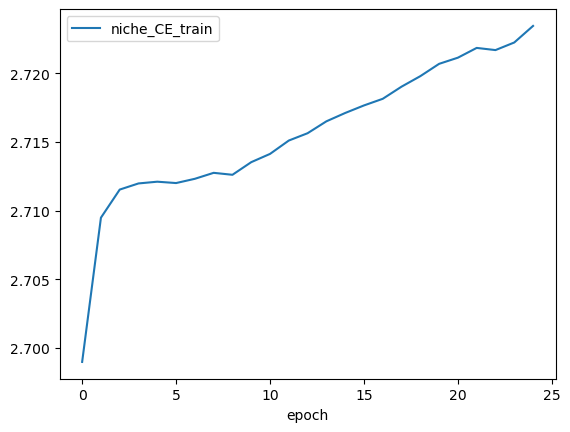

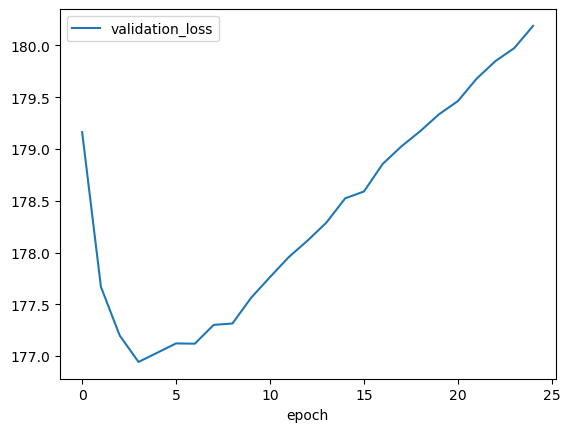

In [90]:
# nichevae.history["reconstruction_loss_train"].plot()
# nichevae.history["niche_kl_train"].plot()

history_setup["cell_type_setup_mixture"]["reconstruction_loss_train"].plot()
history_setup["cell_type_setup_mixture"]["niche_kl_train"].plot()
history_setup["cell_type_setup_mixture"]["niche_CE_train"].plot()
history_setup["cell_type_setup_mixture"]["validation_loss"].plot()

In [77]:
# history_setup['cell_type_setup_mixture']['kl_local_train'].plot()

In [33]:
print(adata.obsm)

AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, spatial, 
qz1_m, qz1_var, niche_indexes, niche_distances, qz1_m_niche_ct, qz1_var_niche_ct, 
X_nicheVI_cell_type_setup_mixture, X_nicheVI_cell_type_unweighted_setup_mixture

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


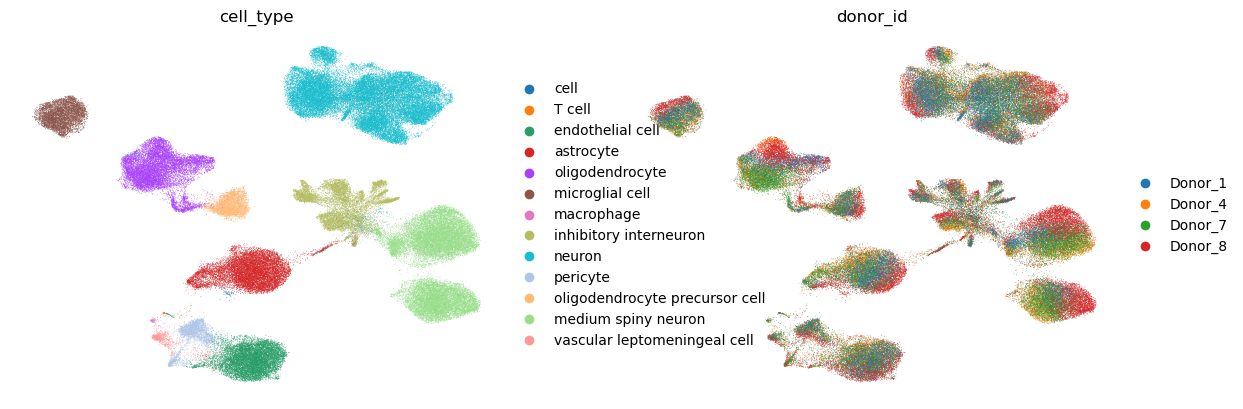

In [72]:
sc.pp.neighbors(adata, use_rep="X_nicheVI_cell_type_setup_mixture")
sc.tl.umap(adata, min_dist=0.3)


sc.pl.umap(
    adata,
    color=["cell_type", "donor_id"],
    ncols=2,
    frameon=False,
)

In [26]:
# history_setup['knn_setup']["reconstruction_loss_train"].plot()
# history_setup['knn_setup']["niche_kl_train"].plot()

In [27]:
# sc.pp.neighbors(adata, use_rep="X_nicheVI_knn_setup")
# sc.tl.umap(adata, min_dist=0.3)


# sc.pl.umap(
#     adata,
#     color=["cell_type", "donor_id"],
#     ncols=2,
#     frameon=False,
# )

## scVI

In [95]:
is_trained = False
save_scvi = False

if is_trained == False:
    scvi.model.SCVI.setup_anndata(
        adata,
        layer="counts",
        batch_key="donor_id",
    )

    scvivae = scvi.model.SCVI(
        adata,
        gene_likelihood="poisson",
        n_layers=1,
        n_latent=10,
    )

    scvivae.train(
        max_epochs=20,
        train_size=0.8,
        validation_size=0.2,
        plan_kwargs=dict(n_epochs_kl_warmup=80, weight_decay=1e-3),
        early_stopping=True,
    )

    if save_scvi:
        scvivae.save(dir_path=path_to_save + "/scvivae.pt", save_anndata=False)

if is_trained:
    scvivae = scvi.model.SCVI.load(dir_path=path_to_save + "/scvivae.pt", adata=adata)

adata.obsm["X_scVI"] = scvivae.get_latent_representation()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/20:  55%|█████▌    | 11/20 [00:39<00:32,  3.56s/it, v_num=1, train_loss_step=173, train_loss_epoch=179]

In [86]:
scvivae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<Axes: xlabel='epoch'>

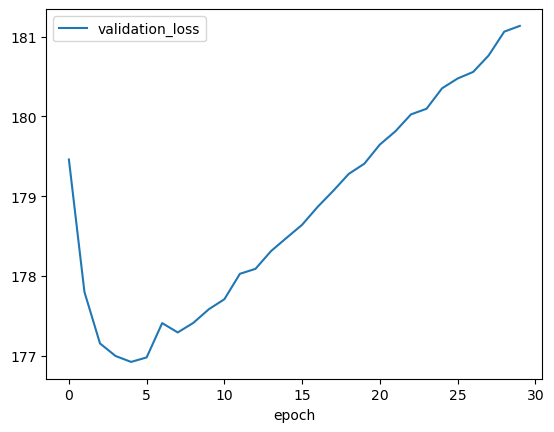

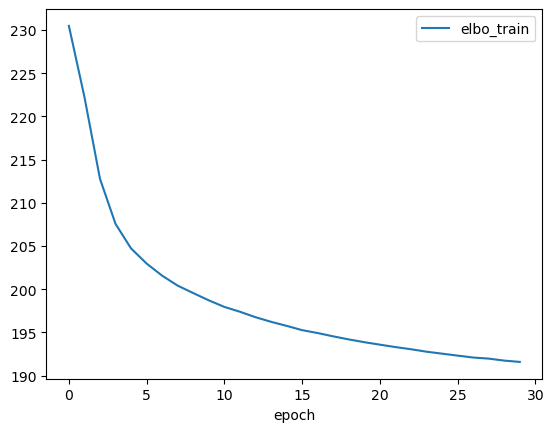

In [87]:
scvivae.history["validation_loss"].plot()
scvivae.history["elbo_train"].plot()

In [92]:
scvi.settings.seed = 34

Global seed set to 34


<Axes: xlabel='epoch'>

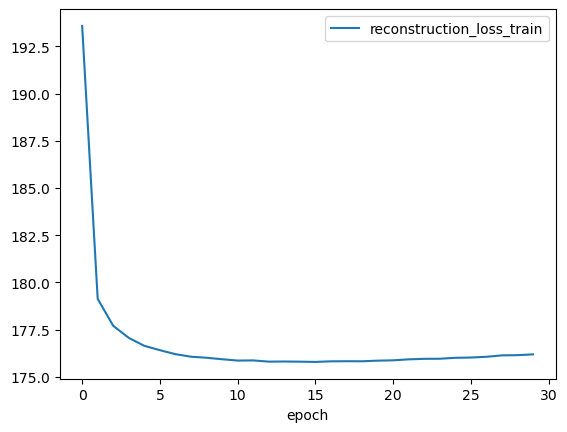

In [52]:
scvivae.history["reconstruction_loss_train"].plot()

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


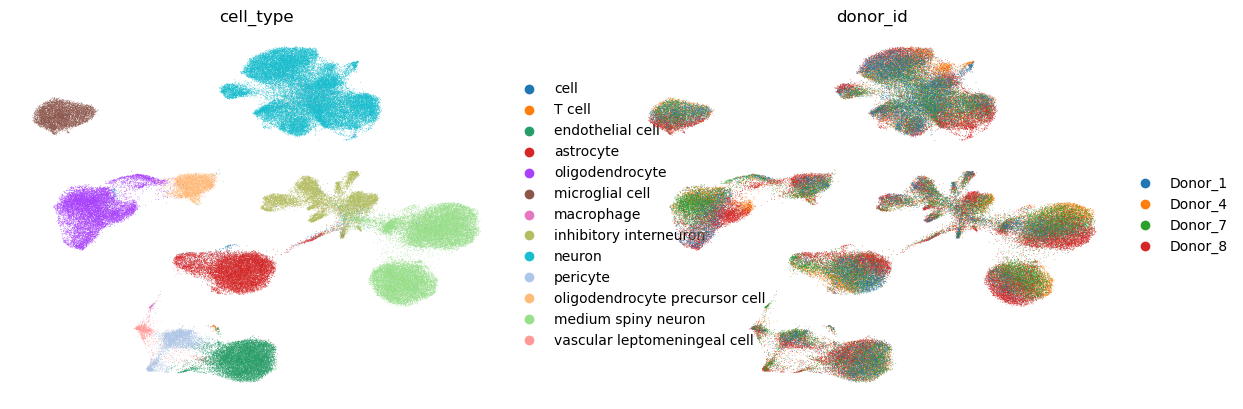

In [53]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)


sc.pl.umap(
    adata,
    color=["cell_type", "donor_id"],
    ncols=2,
    frameon=False,
)

## scib-metrics

In [83]:
adata.obsm["X_ldvae"] = adata.obsm["qz1_m"]
adata.obsm["X_scVI"] = scvivae.get_latent_representation()

print(adata.obsm)

AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, spatial, 
qz1_m, qz1_var, niche_indexes, niche_distances, qz1_m_niche_ct, qz1_var_niche_ct, 
X_nicheVI_cell_type_setup_mixture, X_nicheVI_cell_type_unweighted_setup_mixture, X_ldvae

In [84]:
bm = Benchmarker(
    adata,
    batch_key="donor_slice",
    label_key="cell_type",
    embedding_obsm_keys=[
        "X_pca",
        "X_ldvae",
        "X_scVI",
        "X_nicheVI_cell_type_setup_mixture",
        # "X_nicheVI_knn_setup",
        "X_nicheVI_cell_type_unweighted_setup_mixture",
    ],
    n_jobs=6,
)
bm.benchmark()

Embeddings: 100%|██████████| 5/5 [28:43<00:00, 344.68s/it]


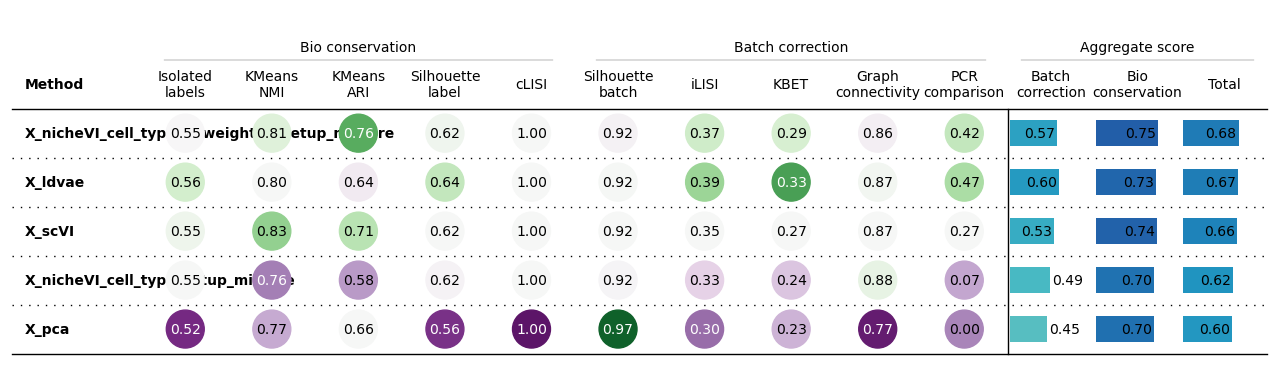

In [85]:
bm.plot_results_table(min_max_scale=False)

## spatial metrics

In [74]:
sa = SpatialAnalysis(
    adata=adata,
    label_key="cell_type",
    sample_key="donor_slice",
    latent_space_keys=[
        "X_scVI",
        "X_nicheVI_cell_type_setup_mixture",
        # "X_nicheVI_knn_setup",
        "X_nicheVI_cell_type_unweighted_setup_mixture",
    ],
    spatial_coord_key="centroids",
    ct_composition_key="neighborhood_composition",
)

In [75]:
sa.compute_metrics(
    k_nn=21,  #what is the optimal k_nn?
    set_of_metrics=["distance", "similarity", "latent_overlap"],
    similarity_metric="spearman",
    reduction=["median", "mean"],
    z2_versus_z1=["X_scVI", "X_nicheVI_cell_type_setup_mixture"],
)

X_scVI

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:45<00:00, 16.59s/it]


The latent and physical correlation and neighborhood similarity are saved in the.obs columns: 
latent_and_phys_corr_X_scVI and neighborhood_similarity_X_scVI.

X_nicheVI_cell_type_setup_mixture

100%|██████████| 10/10 [02:45<00:00, 16.51s/it]


The latent and physical correlation and neighborhood similarity are saved in the.obs columns: 
latent_and_phys_corr_X_nicheVI_cell_type_setup_mixture and 
neighborhood_similarity_X_nicheVI_cell_type_setup_mixture.

X_nicheVI_cell_type_unweighted_setup_mixture

100%|██████████| 10/10 [02:44<00:00, 16.45s/it]


The latent and physical correlation and neighborhood similarity are saved in the.obs columns: 
latent_and_phys_corr_X_nicheVI_cell_type_unweighted_setup_mixture and 
neighborhood_similarity_X_nicheVI_cell_type_unweighted_setup_mixture.

The latent spaces overlap is saved in the.obs column: latent_overlap.

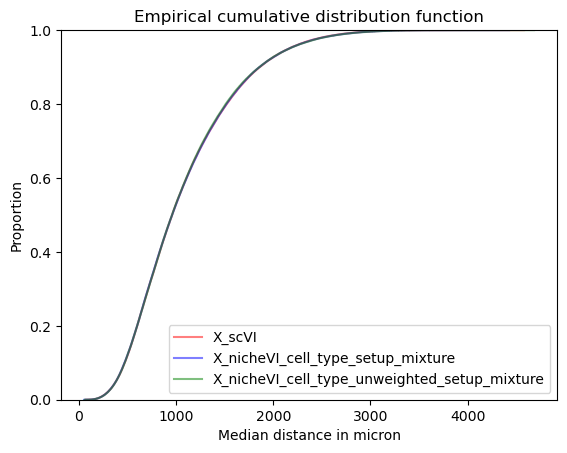

In [76]:
# sa.plot_distance(plot_type='kde', split_by_key='cell_type')
sa.plot_distance(plot_type="ecdf", split_by_key=None)

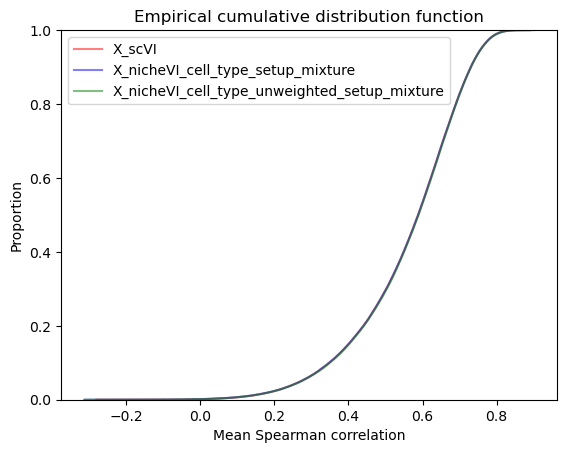

In [77]:
sa.plot_similarity(plot_type="ecdf")

In [80]:
sa.get_latent_overlap()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Cell type                      ┃ #Cells ┃ Average Jaccard ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ endothelial cell               │ 11376  │ 0.16            │
│ oligodendrocyte precursor cell │ 4234   │ 0.22            │
│ neuron                         │ 34553  │ 0.22            │
│ astrocyte                      │ 12830  │ 0.18            │
│ inhibitory interneuron         │ 10330  │ 0.27            │
│ pericyte                       │ 3443   │ 0.32            │
│ oligodendrocyte                │ 13110  │ 0.25            │
│ microglial cell                │ 6317   │ 0.21            │
│ vascular leptomeningeal cell   │ 1137   │ 0.4             │
│ medium spiny neuron            │ 25667  │ 0.16            │
│ macrophage                     │ 355    │ 0.3             │
│ T cell                         │ 45     │ 0.36            │
│ cell                           │ 235    │ 0.27            │
└────────────────────────────────┴────────┴─────────────────┘

In [62]:
sa.get_latent_overlap()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Cell type                      ┃ #Cells ┃ Average Jaccard ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ endothelial cell               │ 11376  │ 0.12            │
│ oligodendrocyte precursor cell │ 4234   │ 0.17            │
│ neuron                         │ 34553  │ 0.14            │
│ astrocyte                      │ 12830  │ 0.12            │
│ inhibitory interneuron         │ 10330  │ 0.21            │
│ pericyte                       │ 3443   │ 0.24            │
│ oligodendrocyte                │ 13110  │ 0.17            │
│ microglial cell                │ 6317   │ 0.16            │
│ vascular leptomeningeal cell   │ 1137   │ 0.3             │
│ medium spiny neuron            │ 25667  │ 0.12            │
│ macrophage                     │ 355    │ 0.23            │
│ T cell                         │ 45     │ 0.2             │
│ cell                           │ 235    │ 0.17            │
└────────────────────────────────┴────────┴─────────────────┘

In [50]:
# spatial_latent_analysis(
#     sample_key="donor_slice",
#     latent_space_keys=[
#         "X_ldvae",
#         "X_nicheVI_cell_type_setup_mixture",
#         # "X_nicheVI_knn_setup",
#         # "X_nicheVI_knn_unweighted_setup_mixture",
#     ],
#     ct_composition_key="neighborhood_composition",
#     adata=adata,
#     path=None,
#     k_nn=13,
#     sample_subset=None,
#     set_of_metrics=["distance", "similarity"],
#     spatial_coord_key="centroids",
#     similarity_metric="spearman",
#     reduction=["median", "mean"],
#     inplace=True,
# )

In [55]:
# adata.write_h5ad("data/nicheVI.h5ad")

In [33]:
adata = ad.read_h5ad("data/nicheVI.h5ad")

In [28]:
print(adata)

AnnData object with n_obs × n_vars = 123632 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice', 'n_counts', 'cell_index', '_scvi_batch', '_scvi_labels', 'index'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'donor_id_colors', 'log1p', 'neighbors', 'pca', 
'umap', 'qz1_m_niche_ct_prior', 'qz1_var_niche_ct_prior'
    obsm: 'X_pca', 'X_scVI', 'X_spVI', 'X_spatial', 'X_umap', 'centroids', 'neighborhood_composition', 'spatial', 
'qz1_m', 'qz1_var', 'niche_indexes', 'niche_distances', 'qz1_m_niche_knn', 'qz1_var_niche_knn', 'qz1_m_niche_ct', 
'qz1_var_niche_ct', 'X_nicheVI_cell_type_setup_mixture', 'X_nicheVI_cell_type_unweighted_setup_mixture', 'X_ldvae'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [65]:
# sns.kdeplot(
#     data=adata.obs["latent_and_phys_corr_X_ldvae"],
#     label="Linear scVI",
#     color="red",
#     alpha=0.5,
# )
# sns.kdeplot(
#     data=adata.obs["latent_and_phys_corr_X_nicheVI_cell_type_setup_mixture"],
#     label="Niche scVI - ct",
#     color="blue",
#     alpha=0.5,
# )
# # sns.kdeplot(
# #     data=adata.obs["latent_and_phys_corr_X_nicheVI_knn_setup"],
# #     label="Niche scVI - knn",
# #     color="green",
# #     alpha=0.5,
# # )
# plt.xlabel("Median distance in micron")
# # plt.title("Donor_1-slice_0 - medium spiny neurons")
# plt.legend()  # Add a legend to display the labels
# plt.show()

In [66]:
# sns.kdeplot(
#     data=adata.obs["neighborhood_similarity_X_ldvae"],
#     label="Linear scVI",
#     color="red",
#     alpha=0.5,
# )
# sns.kdeplot(
#     data=adata.obs["neighborhood_similarity_X_nicheVI_cell_type_setup_mixture"],
#     label="Niche scVI - ct",
#     color="blue",
#     alpha=0.5,
# )
# # sns.kdeplot(
# #     data=adata.obs["neighborhood_similarity_X_nicheVI_knn_setup"],
# #     label="Niche scVI - knn",
# #     color="green",
# #     alpha=0.5,
# # )
# plt.xlabel("Mean Spearman correlation")
# # plt.title("Donor_1-slice_0 - medium spiny neurons")
# plt.legend()  # Add a legend to display the labels
# plt.show()

## EXPERIMENTS

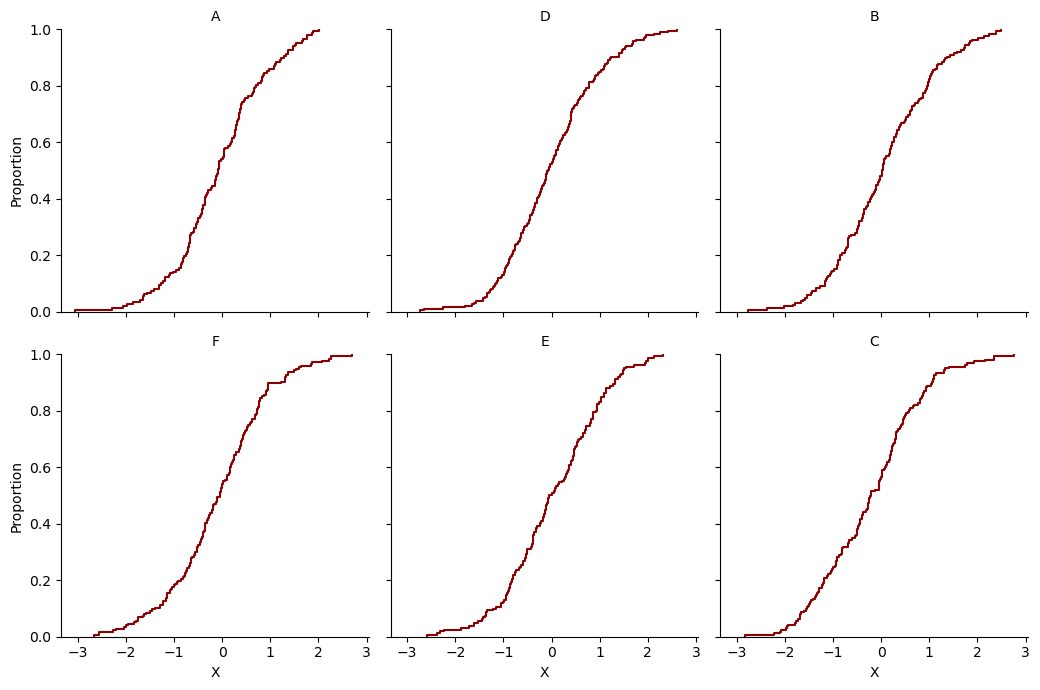

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)
X = np.random.randn(1000)
categories = np.random.choice(["A", "B", "C", "D", "E", "F"], size=1000)

# Create a DataFrame
data = pd.DataFrame({"X": X, "Category": categories})

# Create a FacetGrid with subplots
g = sns.FacetGrid(data, col="Category", col_wrap=3, height=3.5, sharey=True)

# Map an ECDF plot to the FacetGrid
g.map(sns.ecdfplot, "X", color="darkred")

# Add titles to the subplots
g.set_titles(col_template="{col_name}")

# Adjust layout
g.tight_layout()

# Show the plots
plt.show()

In [36]:
def jaccard_index(neighbors1, neighbors2):
    intersection = np.intersect1d(neighbors1, neighbors2)
    union = np.union1d(neighbors1, neighbors2)

    if len(union) == 0:
        jaccard = 0.0
    else:
        jaccard = len(intersection) / len(union)

    return jaccard


# Example matrices of neighboring indices
neighbors_matrix1 = np.array([[1, 2, 3], [0, 2, 3], [0, 1, 2], [1, 2, 4]])

neighbors_matrix2 = np.array([[1, 3, 4], [0, 2, 1], [0, 1, 6], [0, 2, 3]])

# Calculate Jaccard index
jaccard = jaccard_index(neighbors_matrix1, neighbors_matrix2)
print("Jaccard Index:", jaccard)
# Compute Jaccard index for each row
jaccard_values = [
    jaccard_index(neighbors1, neighbors2)
    for neighbors1, neighbors2 in zip(neighbors_matrix1, neighbors_matrix2)
]
print("Jaccard Index for Each Row:", jaccard_values)
# compute the mean Jaccard index across all rows
mean_jaccard = np.mean(jaccard_values)
print("Mean Jaccard Index:", mean_jaccard)

Jaccard Index: 0.8333333333333334

Jaccard Index for Each Row:
[0.5, 0.5, 0.5, 0.2]

Mean Jaccard Index: 0.425

In [54]:
# Create two random NumPy arrays
array1 = np.random.rand(4, 3)
array2 = np.random.rand(4, 3)

# Build the dictionary
my_dict = {"key1": array1, "key2": array2}

neighbors_matrix1 = list(my_dict.keys())[0]
neighbors_matrix2 = list(my_dict.keys())[1]

jaccard_values = [
    jaccard_index(neighbors1, neighbors2)
    for neighbors1, neighbors2 in zip(neighbors_matrix1, neighbors_matrix2)
]
print("Jaccard Index for Each Row:", jaccard_values)
print(my_dict)

Jaccard Index for Each Row:
[1.0, 1.0, 1.0, 0.0]

{
    'key1': array([[0.30094823, 0.71424379, 0.78303341],
       [0.02304707, 0.96300673, 0.9514686 ],
       [0.60440358, 0.63516401, 0.30853313],
       [0.55009765, 0.70867521, 0.78680026]]),
    'key2': array([[0.35518408, 0.09006519, 0.22017725],
       [0.34630422, 0.54984548, 0.7974789 ],
       [0.44346979, 0.07433549, 0.87603321],
       [0.78130398, 0.72538604, 0.89608294]])
}

In [37]:
import pandas as pd
import numpy as np
import anndata as ad

# Create example data
data = {
    "cat": ["A", "B", "A", "C", "B", "C"],
    "vector_value": [1.2, 3.4, 2.1, 0.9, 4.5, 1.8],
}

# Create adata object
adata = ad.AnnData(pd.DataFrame(data))

# Define the dictionary mapping categories to vector values
category_to_value = {"A": [1.2, 2.1], "B": [3.4, 4.5], "C": [0.9, 1.8]}

# Map the values to the 'cat' column
adata.obs["values"] = adata.obs["cat"].map(category_to_value)

# Convert the 'values' column to ndarray and assign it to adata.obsm
adata.obsm["values"] = np.array(adata.obs["values"].tolist())

print(adata)

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/utils.py:252: UserWarning: X converted to numpy array with dtype object
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.


KeyError: 'cat'

In [18]:
obsm_df = pd.DataFrame(adata.obsm["qz1_m"])


# Add the categorical column from adata.obs to the DataFrame
obsm_df["category"] = adata.obs["cell_type"].values

# Group by the categorical column and calculate the mean for each group
averages_by_category = obsm_df.groupby("category").mean()

# Print the categories along with the corresponding means
# for category, mean_row in averages_by_category.iterrows():
# print(f"Category: {category}")
# print("Mean:")
# print(mean_row)
# print("-" * 30)

averages_by_category = obsm_df.groupby("category").mean()
averages_by_category

,0,1,2,3,4,5,6,7,8,9
category,,,,,,,,,,
cell,-0.296279,0.151823,0.180714,-1.743575,0.334959,-0.414956,0.279052,0.087799,-0.593486,-0.322963
T cell,0.471096,-0.228248,1.162735,-0.947894,0.904605,0.038735,-0.915759,0.979235,0.046201,-2.613263
endothelial cell,-1.736828,-0.030213,-0.533868,-0.523986,1.777097,0.648351,0.043071,0.043116,0.204925,-0.518943
astrocyte,-0.828612,0.582873,0.045768,-1.694357,-0.817811,-0.089259,0.182283,0.490682,-0.714899,0.420824
oligodendrocyte,0.557079,-1.674632,-0.576454,-0.924055,-0.058821,0.492230,-1.375177,-0.208435,0.828474,1.143223
microglial cell,-1.150541,-0.397042,2.516176,0.070420,-0.652185,0.779319,-1.309644,-0.047969,0.631051,-1.083256
macrophage,-0.249474,0.109819,1.106186,-0.664558,-0.115015,-0.397024,-0.029595,-0.165604,0.033586,-1.326156
inhibitory interneuron,0.184607,-0.790034,0.504165,0.420380,-0.354232,-0.116843,1.873967,-0.190367,0.153289,0.129093
neuron,0.690303,1.039164,-0.125058,0.610528,-0.070300,0.005539,-0.079505,-0.080404,0.803937,-0.021505


In [23]:
averages_by_category_dict = averages_by_category.T.to_dict(orient="list")

In [75]:
cell_type_column = "cell_type"

cell_types = adata.obs[cell_type_column].unique().tolist()
# cell_type_to_int = {cell_types[i]: i for i in range(len(cell_types))}
# cell_type_to_int

In [73]:
int_to_cell_types = {i: cell_types[i] for i in range(len(cell_types))}
int_to_cell_types

{0: 'endothelial cell',
 1: 'oligodendrocyte precursor cell',
 2: 'neuron',
 3: 'astrocyte',
 4: 'inhibitory interneuron',
 5: 'pericyte',
 6: 'oligodendrocyte',
 7: 'microglial cell',
 8: 'vascular leptomeningeal cell',
 9: 'medium spiny neuron',
 10: 'macrophage',
 11: 'T cell',
 12: 'cell'}

In [76]:
latent_priors = np.empty((13, 10))
for i in range(13):
    type = int_to_cell_types[i]
    latent_priors[i] = np.mean(
        adata[adata.obs["cell_type"] == type].obsm["qz1_m"], axis=0
    )

In [77]:
latent_priors

array([[-1.7368294 , -0.03021247, -0.53386724, -0.52398545,  1.77709496,
         0.64835161,  0.04307107,  0.04311609,  0.20492482, -0.518942  ],
       [ 0.23852551, -0.01684512,  0.87802786, -0.91966635,  0.3253563 ,
        -2.087852  ,  0.07409973, -1.40342999,  0.02457105,  1.33385265],
       [ 0.69030565,  1.03916073, -0.12505695,  0.61052942, -0.0703005 ,
         0.00553896, -0.07950542, -0.08040449,  0.80393809, -0.02150509],
       [-0.82861215,  0.58287311,  0.04576796, -1.69435298, -0.81781083,
        -0.08925898,  0.18228231,  0.49068263, -0.71489847,  0.42082483],
       [ 0.18460673, -0.79003507,  0.50416517,  0.42037961, -0.35423028,
        -0.11684282,  1.8739624 , -0.19036753,  0.15328865,  0.12909241],
       [-1.52874577,  0.08034428, -1.10485876, -0.59356141,  0.35753503,
        -1.56318164, -0.88596582, -0.92516834, -0.03221156, -1.70433354],
       [ 0.55707788, -1.67463803, -0.5764538 , -0.92405206, -0.05882048,
         0.49223119, -1.37517798, -0.2084351 

In [48]:
ct = ["A", "B", "B", "A", "B", "C"]

averages_by_category_dict = {"A": [0, 0], "B": [0.5, 1.2], "C": [4, 4]}

In [50]:
# ct =  adata.obs['cell_type']
obsm = adata.obsm["cell_type_priors"]


# Create a mapping from cell type to its index in the averages_by_category_dict
# category_to_index = {category: idx for idx, category in enumerate(averages_by_category_dict)}

# Create an array of indices corresponding to the cell types
# category_indices = np.array([category_to_index[category] for category in ct])

# Initialize the adata.obsm['cell_type_priors'] array
n_latent_z1 = len(
    averages_by_category_dict["A"]
)  # Assuming 'A' has the same dimensionality
obsm = np.zeros((len(ct), n_latent_z1))

# Assign the averages using advanced indexing
obsm = np.array([averages_by_category_dict[category] for category in ct])

# print(adata.obsm['cell_type_priors'])
print(obsm)

[[0.  0. ]
 [0.5 1.2]
 [0.5 1.2]
 [0.  0. ]
 [0.5 1.2]
 [4.  4. ]]

In [67]:
adata.obsm["qz1_m_niche_ct_prior"][:20, 1]

array([-0.03021251, -0.01684513, -0.03021251,  1.03916359,  1.03916359,
        0.58287263,  1.03916359,  0.58287263,  1.03916359, -0.01684513,
       -0.01684513,  1.03916359,  1.03916359,  1.03916359, -0.79003417,
        1.03916359,  0.08034427, -1.67463183,  1.03916359,  1.03916359])

In [68]:
adata.obs.cell_type[:20]

275820748261104984743470052142490986087                  endothelial cell
302375575077769376592971920558356036886    oligodendrocyte precursor cell
267807829680073723631714599566507550894                  endothelial cell
51672646721370271404472036583758197146                             neuron
124445072923359013299932652711178203190                            neuron
152576340389784600347427714917378520167                         astrocyte
319013374866959558174102248291655680382                            neuron
70364233930633921478283396906689844270                          astrocyte
325404635088302232429883740121079320051                            neuron
200197334601292114184313163007498997663    oligodendrocyte precursor cell
93615380519420843697121660490979704030     oligodendrocyte precursor cell
39366983246283144387563774323764322977                             neuron
57799460523561656936306772019085139961                             neuron
29545932231550642739913289945025115273

In [ ]:
print(z1_mean_niches.shape)


cell_type_column = "cell_type"
cell_types = adata.obs[cell_type_column].unique().tolist()
cell_type_to_int = {cell_types[i]: i for i in range(len(cell_types))}
integer_vector = np.vectorize(cell_type_to_int.get)(adata.obs[cell_type_column])


n_cells = adata.n_obs
# For each cell, get the cell types of its neighbors
cell_types_in_the_neighborhood = np.vstack(
    [integer_vector[niche_indexes[cell, :]] for cell in range(n_cells)]
)


subset = cell_types_in_the_neighborhood[:5]
print(subset)
# Find the indices of elements with value 2
cell_types = [0, 1, 2, 3]
dict_of_cell_type_indices = {}

for cell_type, cell_type_idx in cell_type_to_int.items():
    ct_row_indices, ct_col_indices = np.where(subset == cell_type_idx)  # [1]
    # ct_array = subset[ct_row_indices, ct_col_indices]
    # print(ct_array)
    result_dict = {}
    for row_idx, col_idx in zip(ct_row_indices, ct_col_indices):
        result_dict.setdefault(row_idx, []).append(col_idx)

    dict_of_cell_type_indices[cell_type] = result_dict

print(dict_of_cell_type_indices)
z1_mean_niches = np.ones((5, k_nn, 1))  # batch times knn times nlatent

z1_mean_niches[0, [6, 6], :] = 2

z1_mean_niches_ct = np.zeros(
    (subset.shape[0], len(cell_type_to_int), 1)
)  # batch times ncelltypes times nlatent
# for cell_type_idx in cell_types:
for cell_type, cell_type_idx in cell_type_to_int.items():
    ct_dict = dict_of_cell_type_indices[cell_type]
    for cell_idx, neighbor_idxs in ct_dict.items():
        z1_mean_niches_ct[cell_idx, cell_type_idx, :] = np.mean(
            z1_mean_niches[cell_idx, neighbor_idxs, :], axis=0
        )
z1_mean_niches_ct[0]

(123632, 20, 10)

[[2 6 2 0 1 4 1 4 0 2 4 2 2 2 0 2 0 2 3 2]
 [2 2 2 2 2 1 6 2 2 0 2 2 4 1 2 3 0 2 3 0]
 [2 2 1 1 3 2 0 2 2 6 2 6 2 2 6 0 2 2 2 1]
 [4 2 0 2 2 4 7 2 2 7 2 0 1 2 2 2 2 0 2 1]
 [2 3 2 0 3 2 2 6 2 2 4 1 1 6 2 1 2 0 4 2]]

{
    'endothelial cell': {0: [3, 8, 14, 16], 1: [9, 16, 19], 2: [6, 15], 3: [2, 11, 17], 4: [3, 17]},
    'oligodendrocyte precursor cell': {0: [4, 6], 1: [5, 13], 2: [2, 3, 19], 3: [12, 19], 4: [11, 12, 15]},
    'neuron': {
        0: [0, 2, 9, 11, 12, 13, 15, 17, 19],
        1: [0, 1, 2, 3, 4, 7, 8, 10, 11, 14, 17],
        2: [0, 1, 5, 7, 8, 10, 12, 13, 16, 17, 18],
        3: [1, 3, 4, 7, 8, 10, 13, 14, 15, 16, 18],
        4: [0, 2, 5, 6, 8, 9, 14, 16, 19]
    },
    'astrocyte': {0: [18], 1: [15, 18], 2: [4], 4: [1, 4]},
    'inhibitory interneuron': {0: [5, 7, 10], 1: [12], 3: [0, 5], 4: [10, 18]},
    'pericyte': {},
    'oligodendrocyte': {0: [1], 1: [6], 2: [9, 11, 14], 4: [7, 13]},
    'microglial cell': {3: [6, 9]},
    'vascular leptomeningeal cell': {},
    'medium spiny neuron': {},
    'macrophage': {},
    'T cell': {},
    'cell': {}
}

array([[1. ],
       [1.5],
       [1. ],
       [1. ],
       [1. ],
       [0. ],
       [1. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ]])

Experiments with **Niche decoder**

In [1]:
nichevae.summary_stats

NameError: name 'nichevae' is not defined

In [ ]:
print(nichevae.module.niche_decoder)

NicheDecoder(
  (decoder): FCLayers(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): None
        (3): ReLU()
        (4): None
      )
    )
  )
  (mean_decoder): Linear(in_features=128, out_features=130, bias=True)
  (var_decoder): Linear(in_features=128, out_features=130, bias=True)
)

In [ ]:
latent_cell = torch.ones((2, 10), device=nichevae.device)  # (batch_size*latent_size)

niche_mean, niche_var = nichevae.module.niche_decoder(
    latent_cell
)  # (batch_size*latent_size*k_nn)

In [ ]:
nichevae.module.n_niche_components

niche_mean_mat = niche_mean.reshape(
    niche_mean.shape[0], nichevae.module.n_niche_components, n_latent_z1
)
niche_var_mat = niche_var.reshape(
    niche_var.shape[0], nichevae.module.n_niche_components, n_latent_z1
)

niche_mean_agg = torch.sum(niche_mean_mat, dim=1)
niche_var_agg = torch.sum(niche_var_mat, dim=1)

In [ ]:
niche_mean_agg.shape

torch.Size([2, 10])

## Code to train compo-scVI

In [ ]:
scvi.model.compoSCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor_id",
    niche_composition_key="neighborhood_composition",
)

n_cell_types = adata.obsm["neighborhood_composition"].shape[1]

compovae = scvi.model.compoSCVI(
    adata,
    gene_likelihood="poisson",
    n_layers=1,
    n_latent=15,
    n_cell_types=n_cell_types,
    ce_weight=10,
)

compovae.train(
    max_epochs=1,
    train_size=0.8,
    validation_size=0.2,
    plan_kwargs=dict(n_epochs_kl_warmup=80),
    early_stopping=False,
)

adata.obsm["ct_pred"] = compovae.predict_neighborhood(softmax=True)

INFO     Using column names from columns of adata.obsm['neighborhood_composition']                                 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it, v_num=1, train_loss_step=195, train_loss_epoch=209]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 1/1: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it, v_num=1, train_loss_step=195, train_loss_epoch=209]
